## Inversion of structurally informed DCM using Python interface

This code demonstrates an example inversion of a small dynamic causal model of networked cortical sources, based on resting state, interictal intracranial EEG recordings. This is done whilst incorporating a set of priors that encode between regional structural connectivity strenghts. The contribution of these structural priors can be tuned with hyperparameters that allow for a low-dimensional mapping between different structural connectivity strengths and the assumed prior effective connection on which the dynamic causal model inversion rests. 

The key inputs to this inversion are a `data` matrix that contains the time series data, and an `options` object that collates the hyperparameter values and the structural connecitivty information. Through these variables, this function can therefore easily integrate with other appraoches such as The Virtual Brain, and with an availabel Matlab Runtime only (i.e. without a full Matlab installation). It is thus readily deployable on cloud computing infrastructures.

### Housekeeping

In [607]:
# Import relevant packages
#================================================================================
import os
import sys
import time
import glob
from importlib import reload
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import mne
from mne_bids import BIDSPath, print_dir_tree
import networkx as nx
import community

In [127]:
# Define local folder structure
#================================================================================
F = {}
F['gdrive'] = '' 
F['base'] = '/Users/roschkoenig/Desktop/2303_si-DCM'
F['data'] = F['base'] +os.sep+ '01_Data'
F['code'] = F['base'] +os.sep+ '02_Code'
F['outp'] = F['base'] +os.sep+ '03_Output'
print_dir_tree(F['data'])

|01_Data/
|--- .DS_Store
|--- testdata.mat


In [326]:
testcase = scipy.io.loadmat(F['data'] +os.sep+ 'testdata.mat')
data     = testcase['data']
options  = testcase['options']

def pyCM(cfg): 
    scipy.io.savemat(cfg['path'], {'cfg':cfg}) 
    runfile     = F['code']+os.sep+'packages/pyCM/for_redistribution_files_only/run_pyCM.sh'
    mlruntime   = '/Applications/MATLAB/MATLAB_Runtime/v912'

    # Run in standalone matlab app
    #-------------------------------------------------------------------------------------------
    os.system('\''+runfile+'\''+' '+'\''+mlruntime+'\''+' '+'\''+cfg['path']+'\'')

### Example input data

The input data in this case are stored in a `.mat` file that contains windowed segments from 6 channels of continuous intracranial EEG data, as well as the connectivity matrices corresponding to the diffusion-MRI structural connectivity measures between the respective brain regions included in the iEEG dataset. The data is illustrated below

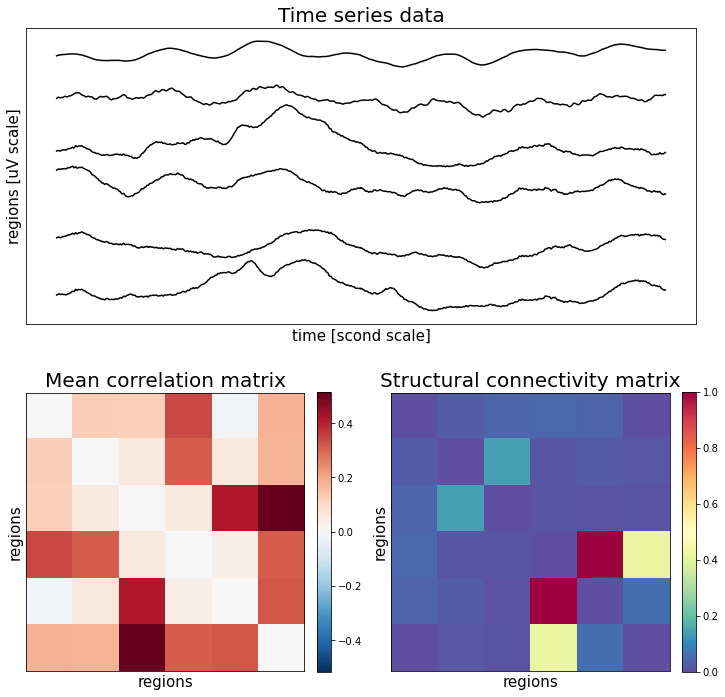

In [612]:
example = 6
fs  = options['fs'][0][0][0][0]
tim = np.arange(data.shape[2])/fs
net = options['structure'][0][0][0][0]['net']

# Plotting routines
#==========================================================================
fig, axs = plt.subplot_mosaic([['u','u'],['ll', 'lr']],figsize=(12,12), facecolor='w')

# Plot example time series data
#--------------------------------------------------------------------------
for i in range(data.shape[1]):
    dat = np.squeeze(data[example,i,:])
    axs['u'].plot(tim, dat-i*1000, 'k')

axs['u'].set_title('Time series data', fontsize = 20)
axs['u'].set_xticks([]), axs['u'].set_xlabel('time [scond scale]', fontsize = 15)
axs['u'].set_yticks([]), axs['u'].set_ylabel('regions [uV scale]', fontsize = 15)   
    
# Plot example correlation matrix
#--------------------------------------------------------------------------
cc = np.zeros((data.shape[0], data.shape[1], data.shape[1]))
for t in range(data.shape[0]):
    tcc = np.corrcoef(data[t,:,:])
    np.fill_diagonal(tcc,0)
    cc[t,:,:] = tcc 

ll = axs['ll'].imshow(np.mean(cc,0), cmap = 'RdBu_r', vmin = -abs(np.mean(cc,0)).max(), vmax = abs(np.mean(cc,0)).max())
plt.colorbar(ll, ax = axs['ll'], fraction=0.046, pad=0.04)
axs['ll'].set_title('Mean correlation matrix', fontsize = 20)
axs['ll'].set_xticks([]), axs['ll'].set_xlabel('regions', fontsize = 15)
axs['ll'].set_yticks([]), axs['ll'].set_ylabel('regions', fontsize = 15) 
    
# Plot structural connectivity matrix 
#--------------------------------------------------------------------------
lr = axs['lr'].imshow(net, cmap = 'Spectral_r', vmin = 0, vmax = abs(net).max())
plt.colorbar(lr, ax = axs['lr'], fraction=0.046, pad=0.04)
axs['lr'].set_title('Structural connectivity matrix', fontsize = 20)
axs['lr'].set_xticks([]), axs['lr'].set_xlabel('regions', fontsize = 15)
axs['lr'].set_yticks([]), axs['lr'].set_ylabel('regions', fontsize = 15) 

plt.show()

### Set up DCM inversion
As a next step this code will use the intracranial EEG data to fit a dynamic causal model of a network of reciprocally connected sources, taking into account the known structural connection strengths between brain regions. 

#### Define hyperparameters

The relationship between structural connectivity values and the prior values placed on teh respective effective connections is modelled through a simple equation with three parameters:  `prior = [s * smax / (1+np.exp(alpha-delta*s))`. The code below sets up this function and illustrates the resultant input-output function for transforming quantitative meausres of structural connectivity to priors for the dynamic causal model inversion.

In [303]:
# Structural connectivity prior matrix
#-------------------------------------------------------------------------------------------
net = options[0][0][0][0]['net'][0]  # matlab files of newer versions are saved in annoying ways
if not net.shape[0] == data.shape[1]: print('WARNING: Structural matrix does not match the data dimensions')

# hyperparameters for scaling of structural priors
#-------------------------------------------------------------------------------------------
alpha = 0.5
delta = 8
smax  = 0.5

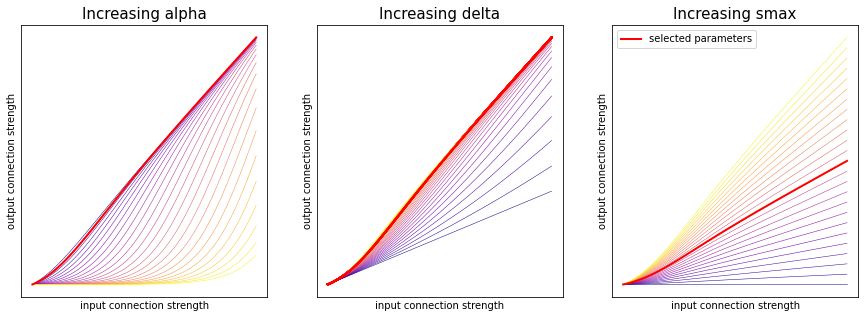

In [314]:
# map onto options variable and save
#========================================================================================
opt = {}
opt['fs']     = np.double(options['fs'][0][0][0][0])
opt['label']  = [l[0] for l in options['label'][0][0][0]]
opt['freqth'] = np.double(options['freqth'][0][0][0][0])
opt['path']   = F['outp'] 

structure = {'net':net, 'alpha':alpha, 'delta':delta, 'smax':smax}
opt['structure'] = structure

specfile = F['outp'] +os.sep+ 'specs.mat'
scipy.io.savemat(specfile, {'opt':opt})


# Plotting routines
#========================================================================================
strengths = np.linspace(0,1,100)
n         = 25
colors = plt.cm.plasma(np.linspace(0,1,n))

fig, axs = plt.subplots(1,3,figsize=(15,5), facecolor='w')
selected_strengths = [s * smax / (1+np.exp(alpha-delta*s)) for s in strengths]

k = 0
for a in np.linspace(0,10,n):
    strans = []
    for s in strengths: strans.append(s * smax / (1+np.exp(a-delta*s)))
    axs[0].plot(strengths, strans, color=colors[k], linewidth=.5); k=k+1
axs[0].plot(strengths, selected_strengths, color='r', linewidth=2)
axs[0].set_title('Increasing alpha', fontsize = 15)
axs[0].set_xticks([]), axs[0].set_xlabel('input connection strength', fontsize = 10)
axs[0].set_yticks([]), axs[0].set_ylabel('output connection strength', fontsize = 10)  

k = 0
for d in np.linspace(0,10,n):
    strans = []
    for s in strengths: strans.append(s * smax / (1+np.exp(alpha-d*s)))
    axs[1].plot(strengths, strans, color=colors[k], linewidth=.5); k=k+1

    axs[1].plot(strengths, selected_strengths, color='r', linewidth=2)
axs[1].set_title('Increasing delta', fontsize = 15)
axs[1].set_xticks([]), axs[1].set_xlabel('input connection strength', fontsize = 10)
axs[1].set_yticks([]), axs[1].set_ylabel('output connection strength', fontsize = 10)  

k = 0
for m in np.linspace(0,1,n):
    strans = []
    for s in strengths: strans.append(s * m / (1+np.exp(alpha-delta*s)))
    axs[2].plot(strengths, strans, color=colors[k], linewidth=.5); k=k+1

selected = axs[2].plot(strengths, selected_strengths, color='r', linewidth=2)
axs[2].set_title('Increasing smax', fontsize = 15)
axs[2].set_xticks([]), axs[2].set_xlabel('input connection strength', fontsize = 10)
axs[2].set_yticks([]), axs[2].set_ylabel('output connection strength', fontsize = 10) 
plt.legend(selected, ['selected parameters'])

plt.show()

#### Set up DCM structure 
This function interfaces with theb `pyCM` helper function, which calls the Matlab standalone DCM routine given an input configuration structure (`cfg`). This code will apply the hyperparameters defined above and prepare the DCM located in `cfg['dcm_path]` for inversion. 

In [329]:
specs    = scipy.io.loadmat(F['outp'] +os.sep+ 'specs.mat')
testcase = scipy.io.loadmat(F['data'] +os.sep+ 'testdata.mat')

opts    = specs['opt']      # using custom parameters defined above
data    = testcase['data']  # using test case data


cfg = {}
cfg['path']     = F['code'] +os.sep+ 'config.mat'
cfg['task']     = 'init_siDCM'
cfg['dcm_path'] = F['outp'] +os.sep+ 'DCM.mat'
cfg['data']     = data
cfg['options']  = opts

pyCM(cfg)

------------------------------------------
Setting up environment variables
---
DYLD_LIBRARY_PATH is .:/Applications/MATLAB/MATLAB_Runtime/v912/runtime/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/bin/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/sys/os/maci64
SPM initialising
SPM initialised
Setting up DCM structure
Data type is missing or incorrect, assigning default.

ans = 

  struct with fields:

    M: 0
    A: {[-32]  [-32]  [-32]  [-32]}
    C: 0
    T: [0 0 0 0]
    G: [0 0 0 0]
    D: 0
    S: 0
    R: [0 0]



#### Estimate cross-spectral densities
As a next step, this code will take the time-series data stored in the data file and estimate the complex cross-spectra between iEEG channels across all data segments. This means that for repeat iterations of the cross-spectral densities will not repeatedly be estimated. 

In [395]:
cfg['task'] = 'csd_siDCM'
pyCM(cfg)

------------------------------------------
Setting up environment variables
---
DYLD_LIBRARY_PATH is .:/Applications/MATLAB/MATLAB_Runtime/v912/runtime/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/bin/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/sys/os/maci64
SPM initialising
SPM initialised
Estimating CSD for structurally informed DCM
Data type is missing or incorrect, assigning default.

evaluating CSD for condition 1
CSD estimation complete


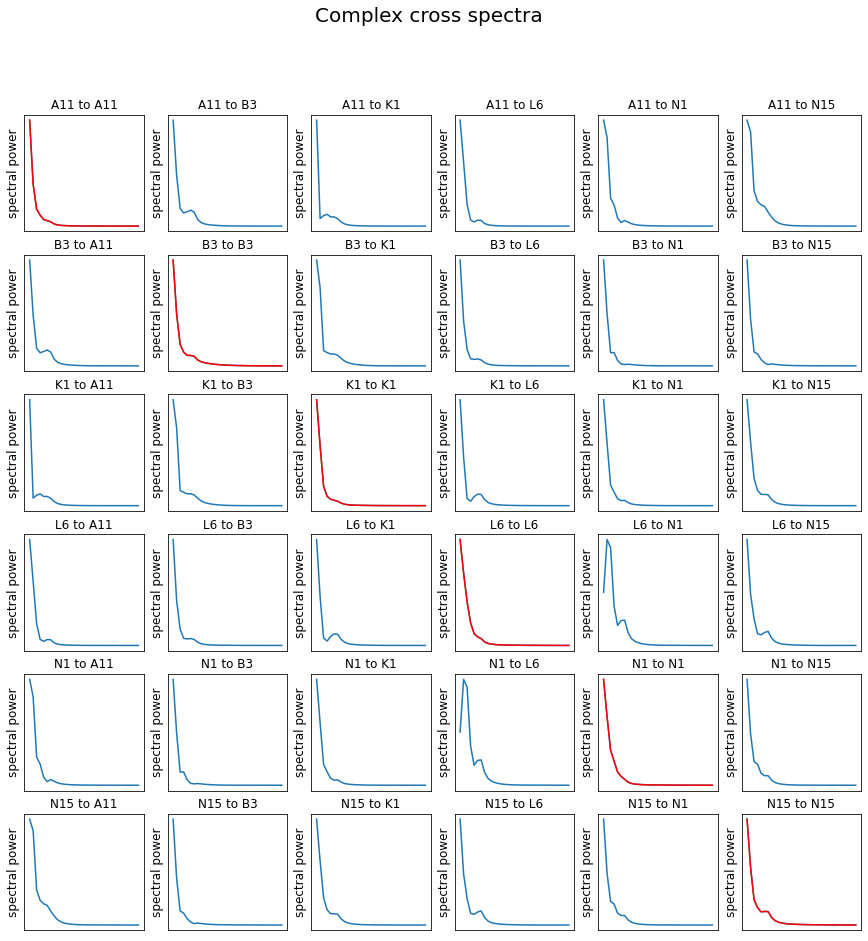

In [462]:
DCM = scipy.io.loadmat(cfg['dcm_path'])['DCM']
y   = DCM['xY'][0][0][0][0]['y'][0][0]
nam = [s[0] for s in DCM['Sname'][0][0][0]]

fig, ax = plt.subplots(len(nam), len(nam), figsize=(15,15), facecolor='w')
fig.suptitle('Complex cross spectra', fontsize=20)
for r1 in range(len(nam)): 
    for r2 in range(len(nam)): 
        ax[r1,r2].plot(abs(y[:,r1,r2]).squeeze())
        ax[r1,r2].set_title(nam[r1]+' to '+nam[r2])
        ax[r1,r2].set_xticks([])
        ax[r1,r2].set_yticks([]), ax[r1,r2].set_ylabel('spectral power', fontsize = 12)
        if r1 == r2:
            ax[r1,r2].plot(abs(y[:,r1,r2]).squeeze(), color='r')

#### Run DCM inversion
Here the actual DCM inversion is performed - the `DCM` structure with the cross spectral densities derived from the data is passed into the standalone `pyCM` Matlab app, which then performs the EM-algorighm based Bayesian model fit. The output of this is the model fit (demonstrated below); Bayesian posterior estimates of the connectivity parameters illustrated further down, and a free energy estimate, which can be used for Bayesian model comparison. 

In [416]:
cfg['task'] = 'inv_siDCM'
pyCM(cfg)

------------------------------------------
Setting up environment variables
---
DYLD_LIBRARY_PATH is .:/Applications/MATLAB/MATLAB_Runtime/v912/runtime/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/bin/maci64:/Applications/MATLAB/MATLAB_Runtime/v912/sys/os/maci64
SPM initialising
SPM initialised
Inverting prepared DCM
EM:(+): 1     F: 0.000e+00 dF predicted: 4.222e+01  actual: 4.305e+01 (53.26 sec)
EM:(+): 2     F: 4.305e+01 dF predicted: 1.035e+02  actual: 1.345e+02 (50.75 sec)
EM:(+): 3     F: 1.775e+02 dF predicted: 3.879e+02  actual: 3.999e+02 (64.47 sec)
EM:(+): 4     F: 5.774e+02 dF predicted: 2.994e+02  actual: 1.667e+02 (56.13 sec)
EM:(+): 5     F: 7.441e+02 dF predicted: 1.872e+01  actual: 1.291e+01 (60.56 sec)
EM:(+): 6     F: 7.570e+02 dF predicted: 6.479e+00  actual: 5.611e+00 (56.56 sec)
EM:(+): 7     F: 7.626e+02 dF predicted: 4.908e+00  actual: 4.434e+00 (50.60 sec)
EM:(+): 8     F: 7.671e+02 dF predicted: 4.417e+00  actual: 3.932e+00 (68.79 sec)
EM:(+): 9     F: 7.710

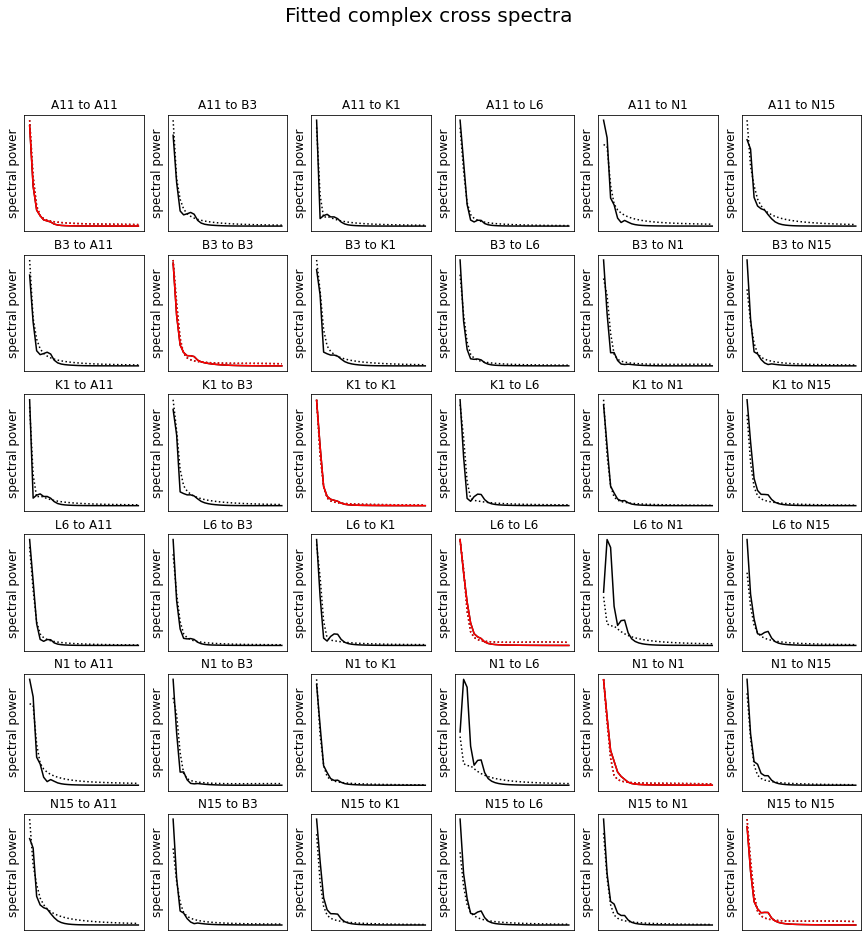

In [511]:
# Plot model fits
#=========================================================================================
# Load parts from DCM structure
#-----------------------------------------------------------------------------------------
DCM = scipy.io.loadmat(cfg['dcm_path'])['DCM']
y   = DCM['xY'][0][0][0][0]['y'][0][0]
Hc  = DCM['Hc'][0][0][0][0]
nam = [s[0] for s in DCM['Sname'][0][0][0]]

fig, ax = plt.subplots(len(nam), len(nam), figsize=(15,15), facecolor='w')
fig.suptitle('Fitted complex cross spectra', fontsize=20)
for r1 in range(len(nam)): 
    for r2 in range(len(nam)):
        ax[r1,r2].plot(abs(y[:,r1,r2]), 'k')
        ax[r1,r2].plot(abs(Hc[:,r1,r2]), 'k:')
        ax[r1,r2].set_title(nam[r1]+' to '+nam[r2])
        ax[r1,r2].set_xticks([])
        ax[r1,r2].set_yticks([]), ax[r1,r2].set_ylabel('spectral power', fontsize = 12)
        if r1 == r2:
            ax[r1,r2].plot(abs(y[:,r1,r2]).squeeze(), color='r')
            ax[r1,r2].plot(abs(Hc[:,r1,r2]), 'r:')

### Plot of effective connectivity network estimate
This section demonstrates the output of the DCM in terms of effective (between-region) connectivity on comparison to the structural connectivity priors incorporated in the network inversion. 

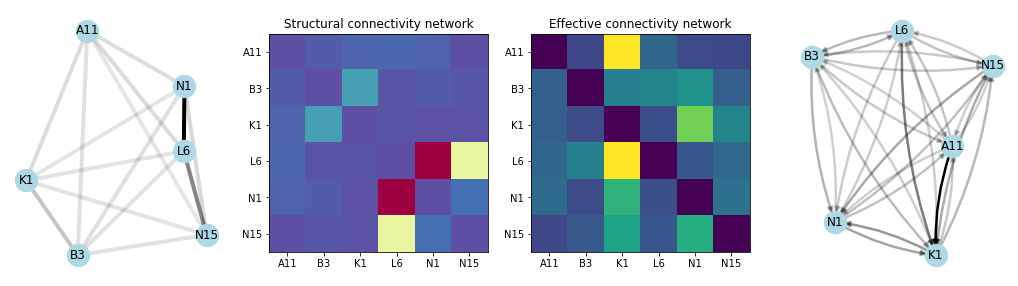

In [621]:
A1 = DCM['Ep'][0][0][0][0]['A'][0][0]
A2 = DCM['Ep'][0][0][0][0]['A'][0][1]
A3 = DCM['Ep'][0][0][0][0]['A'][0][2]
nam = [n[0] for n in DCM['Sname'][0][0][0]]

A   = np.exp(A1+A2+A3); 
for a in range(len(A)): A[a,a] = 0
net = opt['structure']['net']

# Plotting routines
#============================================================================================
fig, ax = plt.subplots(1,4, figsize=(18,5), facecolor='w')
min_alpha = 0.1

# structural connectivity graph
#--------------------------------------------------------------------------------------------
n     = pd.DataFrame(net, index=nam, columns=nam)
G     = nx.from_pandas_adjacency(n)
pos   = nx.spring_layout(G)

# Define the opacity of the edges based on their weights
weights   = nx.get_edge_attributes(G, 'weight')
weights   = {k: v for k, v in weights.items()}
alphas    = [min_alpha + (1-min_alpha) * weights.get((u, v), 0) / max(weights.values()) for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, ax=ax[0], node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos=pos, ax=ax[0], alpha=alphas, width=4)
nx.draw_networkx_labels(G, pos, ax=ax[0])
ax[0].axis('off')

# Adjacency Matrix
ax[1].imshow(net, cmap = 'Spectral_r', vmin=0)
ax[1].set_yticks(np.linspace(0,len(nam)-1,len(nam)), nam)
ax[1].set_xticks(np.linspace(0,len(nam)-1,len(nam)), nam)
ax[1].set_title('Structural connectivity network')

# effective connectivity graph
#--------------------------------------------------------------------------------------------
G     = nx.from_pandas_adjacency(pd.DataFrame(A,index=nam,columns=nam), create_using=nx.DiGraph())
pos   = nx.spring_layout(G)

# Define the opacity of the edges based on their weights
weights   = nx.get_edge_attributes(G, 'weight')
weights   = {k: v for k, v in weights.items()}
alphas    = [min_alpha + (1-min_alpha) * weights.get((u, v), 0) / max(weights.values()) for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, ax=ax[3], node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos=pos, ax=ax[3], alpha=alphas, connectionstyle='arc3, rad = 0.1', width=2.5)
nx.draw_networkx_labels(G, pos, ax=ax[3])
ax[3].axis('off')

# Adjacency Matrix
ax[2].imshow(A, vmin=0, vmax=4)
ax[2].set_title('Effective connectivity network')
ax[2].set_yticks(np.linspace(0,len(nam)-1,len(nam)), nam)
ax[2].set_xticks(np.linspace(0,len(nam)-1,len(nam)), nam)

plt.show()
